In [257]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from itertools import islice
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
from gensim import corpora
from gensim.models import LdaModel
from gensim.test.utils import common_texts
from gensim.utils import simple_preprocess
from gensim.matutils import corpus2dense
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer

In [258]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [259]:
# Define the custom Hellinger distance function
def hellinger(p, q):
  return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2)

In [260]:
# Load data
df = pd.read_csv('final_output.csv')

# Preprocessing text data
df['OGdata'] = df['data']
df['data'] = df['data'].str.replace(r'http\S+', '', regex=True)  # Remove URLs
df['data'] = df['data'].str.replace(r'[^A-Za-z0-9\s]+', '', regex=True)  # Clean special characters
df['data'] = df['data'].str.replace(r'deleted', '', regex=True)  # Clean special characters


tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
def preprocess(text):
    tokens = tokenizer.tokenize(text.lower())
    filtered_tokens = [w for w in tokens if not w in stop_words]
    return " ".join(filtered_tokens)

def stem_words(text):
  porter_stemmer = PorterStemmer()
  tokens = tokenizer.tokenize(text.lower())
  stemmed_tokens = [porter_stemmer.stem(word) for word in tokens]
  stemmed_text = ' '.join(stemmed_tokens)

  return stemmed_text
def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  tokens = tokenizer.tokenize(text)
  filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
  filtered_text = ' '.join(filtered_tokens)

  return filtered_text
def remove_punctuation(text):
  return re.sub(r'[^\w\s]', '', text)

df['data'] = df['data'].apply(preprocess)
df['data'] = df['data'].apply(preprocess)

# Aggregating posts by subreddit
grouped_data = df.groupby('SOURCE_SUBREDDIT')['data'].apply(' '.join)

In [262]:
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['data'])

In [263]:
# Step 4: LDA topic modeling
num_topics = 3
corpus = gensim.matutils.Sparse2Corpus(tfidf_matrix, documents_columns=False)
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=10)

# Step 5: Compute Hellinger distance and clustering
topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

# print(topic_distributions)
dense_distributions = np.array([corpus2dense([dist], num_terms=num_topics).flatten() for dist in topic_distributions])


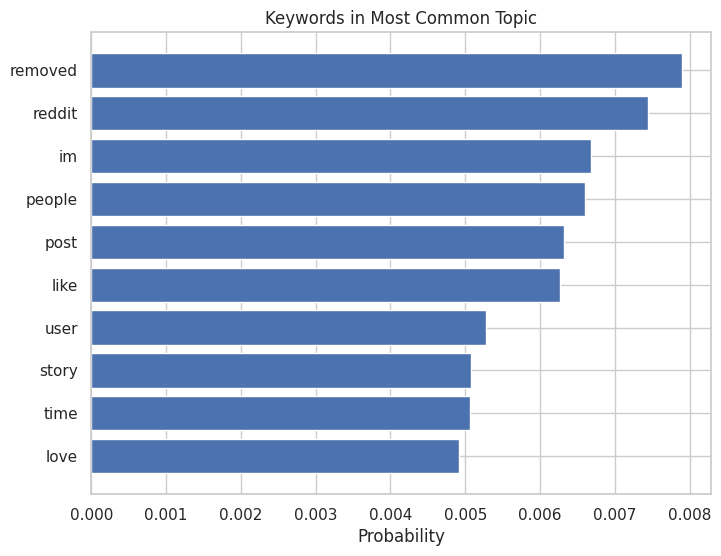

Most common topic is Topic 0:
removed: 0.0079
reddit: 0.0074
im: 0.0067
people: 0.0066
post: 0.0063
like: 0.0063
user: 0.0053
story: 0.0051
time: 0.0051
love: 0.0049


In [264]:
# Step 6: Topic Keyword Visualization
topic_counts = np.zeros(num_topics)
for doc_topics in topic_distributions:
    for topic_num, prob in doc_topics:
        topic_counts[topic_num] += prob

most_common_topic = np.argmax(topic_counts)
topic_keywords = lda_model.show_topic(most_common_topic)
keywords, probabilities = zip(*topic_keywords)

plt.figure(figsize=(8, 6))
plt.barh(keywords, probabilities)
plt.xlabel('Probability')
plt.title('Keywords in Most Common Topic')
plt.gca().invert_yaxis()
plt.show()

# Display the most common topic's content
print(f"Most common topic is Topic {most_common_topic}:")
for word, prob in topic_keywords:
    print(f"{word}: {prob:.4f}")

In [265]:
# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

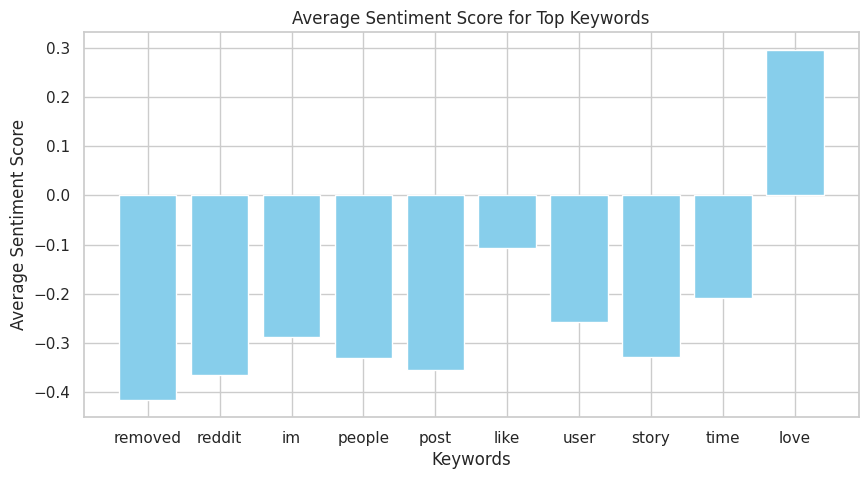

In [272]:
subreddit_sentiments = {keyword: [] for keyword in keywords}

# Compute sentiment scores for top keywords
for keyword in keywords:
    filtered_data = df[df['data'].str.contains(keyword)]
    sentiments = filtered_data['data'].apply(lambda x: sia.polarity_scores(x)['compound'])
    subreddit_sentiments[keyword].append(sentiments.mean())

# Extracting the keyword and sentiment score pairs
keywords = list(subreddit_sentiments.keys())
average_sentiments = [np.mean(sentiments) if sentiments else 0 for sentiments in subreddit_sentiments.values()]

# Creating a bar graph
plt.figure(figsize=(10, 5))
plt.bar(keywords, average_sentiments, color='skyblue')
plt.xlabel('Keywords')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score for Top Keywords')
plt.show()

In [247]:
def get_sentiment(text):
  sid = SentimentIntensityAnalyzer()
  scores = sid.polarity_scores(text)
  return scores['compound']

In [248]:
def get_subreddit_senti(content):
  # input: all text in a subreddit
  sent_level = []
  for i in content.split('.'):
    sent_level.append(get_sentiment(i))

  return sum(sent_level)/len(sent_level)

In [249]:
def get_subreddit_topic(posts):
  # input: list of all posts in subreddit
  clean_documents = [remove_stopwords(doc) for doc in posts]
  clean_documents = [remove_punctuation(doc) for doc in clean_documents]
  clean_documents = [stem_words(doc) for doc in clean_documents]

  processed_docs = [simple_preprocess(doc) for doc in clean_documents]
  dictionary = corpora.Dictionary(processed_docs)
  bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

  lda_model = LdaModel(bow_corpus, num_topics=3, id2word=dictionary, passes=10)

  for idx, topic in lda_model.print_topics(-1):
      print("Topic: {} \nWords: {}".format(idx, topic))

  return lda_model

In [250]:
def get_subreddit_topic_senti(posts, lda_model):
  # input: list of all posts in subreddit, lda model which has topics
  clean_documents = [remove_stopwords(doc) for doc in posts]
  clean_documents = [remove_punctuation(doc) for doc in clean_documents]
  clean_documents = [stem_words(doc) for doc in clean_documents]

  processed_docs = [simple_preprocess(doc) for doc in clean_documents]
  dictionary = corpora.Dictionary(processed_docs)
  bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

  sentiment_scores_dict = {"0": (0, 1),
                          "1": (0, 1),
                          "2": (0, 1)}
  for i in range(len(posts)):
    topics = lda_model.get_document_topics(bow_corpus[i])
    topics = sorted(topics, key=lambda x: -x[1])

    sent_level = []
    doc = posts[i]
    for i in doc.split('.'):
      sent_level.append(get_sentiment(i))

    sentiment_scores_dict[str(topics[0][0])] = (sentiment_scores_dict[str(topics[0][0])][0] + sum(sent_level)/len(sent_level), sentiment_scores_dict[str(topics[0][0])][1] + 1)
    # break

  for key in sentiment_scores_dict.keys():
    print(key, sentiment_scores_dict[key][0]/sentiment_scores_dict[key][1])

  return sentiment_scores_dict

In [251]:
i = 0
LDA_models = []
subreddits = []
subreddit_sentis = []
subreddit_topic_sentis_dicts = []
for subreddit in df['SOURCE_SUBREDDIT'].unique():
  subreddits.append(subreddit)
  df_subreddit = df[df['SOURCE_SUBREDDIT'] == subreddit]
  posts = df_subreddit['OGdata'].tolist()
  posts_combined = ''
  for post in posts:
    posts_combined += post

  subreddit_senti = get_subreddit_senti(posts_combined)
  subreddit_sentis.append(subreddit_senti)
  # print(subreddit, end = "------")
  # print(subreddit_senti)

  subreddit_lda_model = get_subreddit_topic(posts)
  LDA_models.append(subreddit_lda_model)
  # print(subreddit)

  subreddit_topic_sentis = get_subreddit_topic_senti(posts, subreddit_lda_model)
  subreddit_topic_sentis_dicts.append(subreddit_topic_sentis)
  # print(subreddit_topic_sentis)
  i += 1
  # print(i)
  # if i % 2 == 0:
  #   break

Topic: 0 
Words: 0.167*"year" + 0.167*"help" + 0.167*"cunt" + 0.167*"happi" + 0.167*"need" + 0.167*"new"
Topic: 1 
Words: 0.167*"happi" + 0.167*"year" + 0.167*"help" + 0.167*"cunt" + 0.167*"need" + 0.167*"new"
Topic: 2 
Words: 0.167*"new" + 0.167*"need" + 0.167*"cunt" + 0.167*"happi" + 0.167*"help" + 0.167*"year"
0 0.0
1 0.0
2 0.26145
Topic: 0 
Words: 0.063*"funni" + 0.063*"http" + 0.063*"gag" + 0.063*"comment" + 0.063*"redditor" + 0.063*"fabric" + 0.062*"annoy" + 0.062*"com" + 0.062*"reddit" + 0.062*"recent"
Topic: 1 
Words: 0.063*"comment" + 0.063*"http" + 0.063*"annoy" + 0.063*"funni" + 0.063*"redditor" + 0.063*"fabric" + 0.063*"recent" + 0.063*"gag" + 0.063*"honor" + 0.062*"stori"
Topic: 2 
Words: 0.063*"steal" + 0.063*"www" + 0.063*"pic" + 0.063*"gift" + 0.063*"honor" + 0.063*"com" + 0.063*"stori" + 0.063*"reddit" + 0.062*"recent" + 0.062*"fabric"
0 0.0
1 0.0
2 -0.010458333333333333
Topic: 0 
Words: 0.115*"scam" + 0.066*"post" + 0.066*"use" + 0.066*"thelegendisher" + 0.066*"somebo

In [252]:
topic_0s = [ data['0'][0]/data['0'][1] for data in subreddit_topic_sentis_dicts]
topic_1s = [ data['1'][0]/data['1'][1] for data in subreddit_topic_sentis_dicts]
topic_2s = [ data['2'][0]/data['2'][1] for data in subreddit_topic_sentis_dicts]

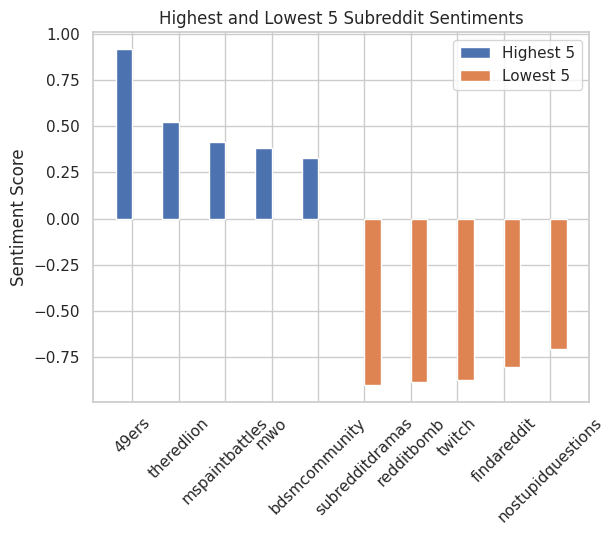

In [253]:
import matplotlib.pyplot as plt
import numpy as np

# Get the highest and lowest 5 values in subreddit_sentis
highest_5_values = np.array(subreddit_sentis).argsort()[-5:][::-1]
lowest_5_values = np.array(subreddit_sentis).argsort()[:5]

# Get the corresponding subreddits and sentiment scores
highest_5_subreddits = np.array(subreddits)[highest_5_values]
lowest_5_subreddits = np.array(subreddits)[lowest_5_values]
highest_5_scores = np.array(subreddit_sentis)[highest_5_values]
lowest_5_scores = np.array(subreddit_sentis)[lowest_5_values]

x = np.arange(10)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x[:5] - width/2, highest_5_scores, width, label='Highest 5')
rects2 = ax.bar(x[5:] + width/2, lowest_5_scores, width, label='Lowest 5')

ax.set_ylabel('Sentiment Score')
ax.set_title('Highest and Lowest 5 Subreddit Sentiments')
ax.set_xticks(x)
ax.set_xticklabels(np.concatenate((highest_5_subreddits, lowest_5_subreddits)), rotation=45)
ax.legend()

plt.show()


[488 305  58  51 233]
[271 521 203 307 685]


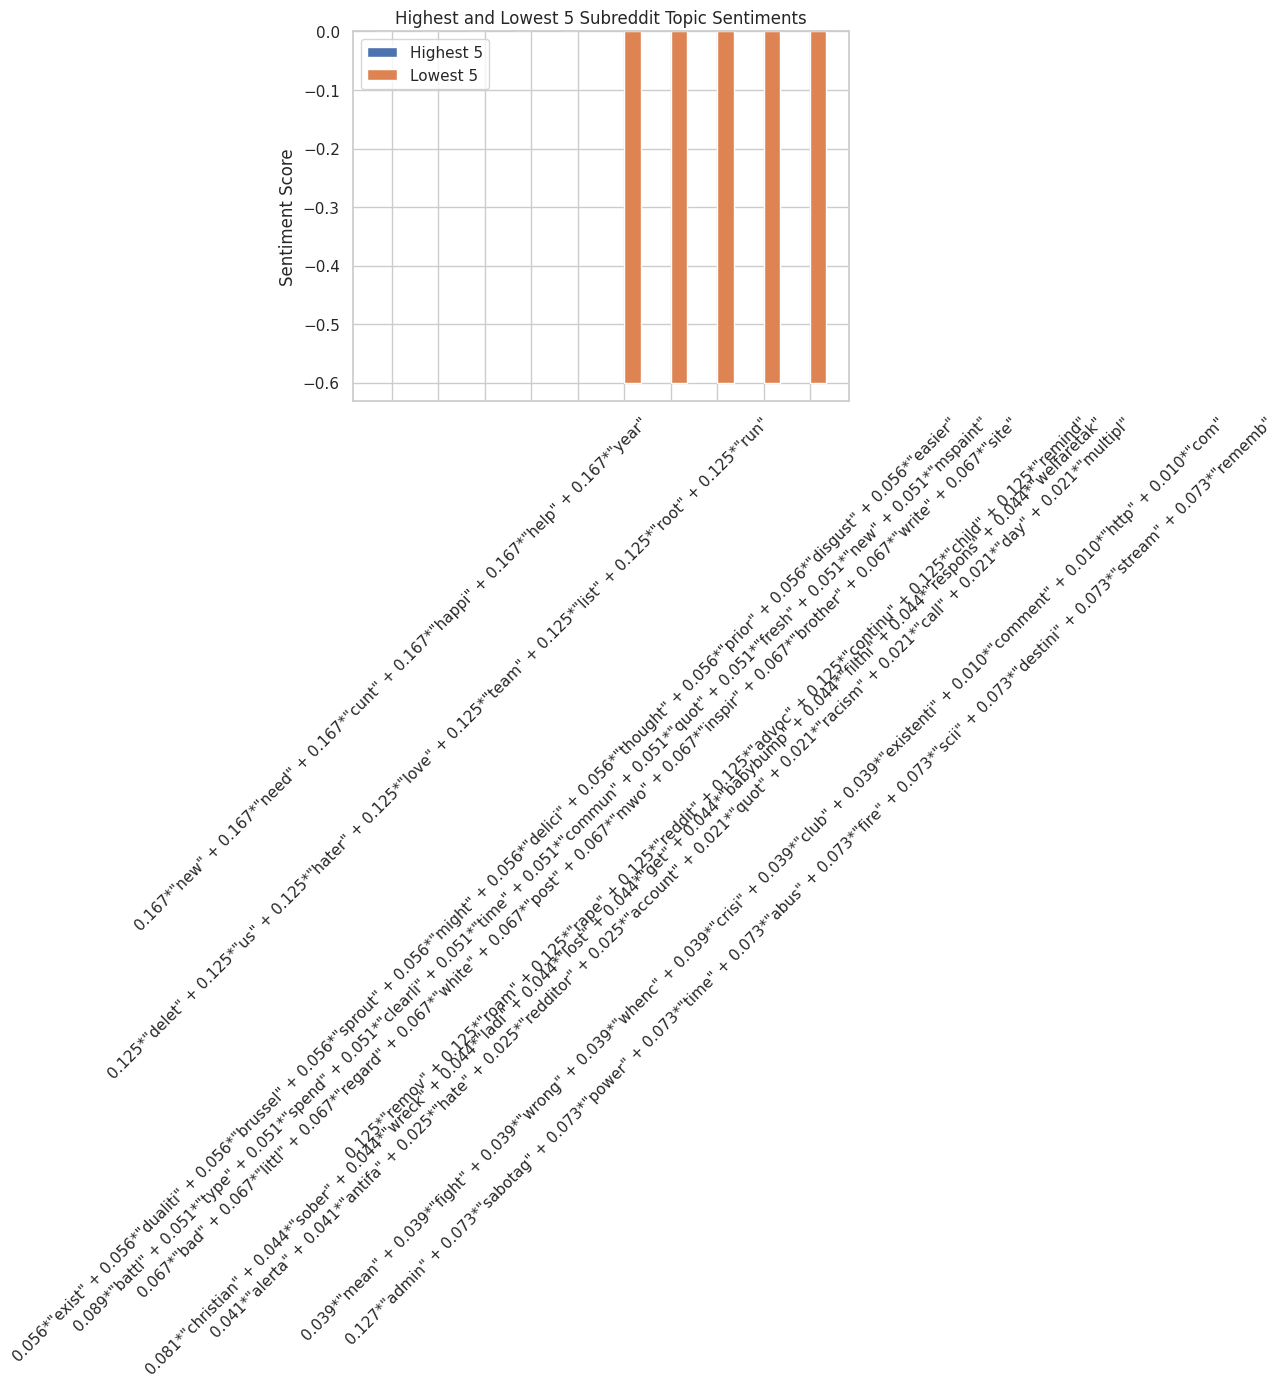

In [254]:
highest_5_values = np.array(topic_0s + topic_1s + topic_2s).argsort()[-5:][::-1]
print(highest_5_values)
lowest_5_values = np.array(topic_0s + topic_1s + topic_2s).argsort()[:5]
print(lowest_5_values)

highest_5_subreddits_topics = np.array([LDA_models[val%244].print_topics()[val//244][1] for val in highest_5_values])
lowest_5_subreddits_topics = np.array([LDA_models[val%244].print_topics()[val//244][1] for val in lowest_5_values])

highest_5_scores_topics = np.array(topic_0s[0%244] + topic_2s[549%244] + topic_2s[546%244] + topic_1s[392%244] + topic_0s[201%244])
lowest_5_scores_topics = np.array(topic_0s[33%244] + topic_2s[515%244] + topic_1s[447%244] + topic_1s[307%244] + topic_0s[197%244])

x = np.arange(10)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x[:5] - width/2, highest_5_scores_topics, width, label='Highest 5')
rects2 = ax.bar(x[5:] + width/2, lowest_5_scores_topics, width, label='Lowest 5')

ax.set_ylabel('Sentiment Score')
ax.set_title('Highest and Lowest 5 Subreddit Topic Sentiments')
ax.set_xticks(x)
ax.set_xticklabels(np.concatenate((highest_5_subreddits_topics, lowest_5_subreddits_topics)), rotation=45)
ax.legend()

plt.show()


In [255]:
# Filter rows with negative sentiment
negative_sentiment = df[df['LINK_SENTIMENT'] == -1]

# Count occurrences of target subreddits
ganged_up_counts = negative_sentiment['TARGET_SUBREDDIT'].value_counts()

# Get the top 5 most ganged up subreddits
top_5_ganged_up_subreddits = ganged_up_counts.head(5)

print("Top 5 most ganged up subreddits:")
print(top_5_ganged_up_subreddits)

# Dictionary to store topics for each subreddit
subreddit_topics = {}

# Iterate over the top 5 subreddits
for subreddit in top_5_ganged_up_subreddits.index:
    # Assuming you have a DataFrame containing posts data
    subreddit_posts = df[df["TARGET_SUBREDDIT"] == subreddit]["data"].tolist()
    lda_model = get_subreddit_topic(subreddit_posts)
    subreddit_topics[subreddit] = lda_model.print_topics(-1)

# Print topics for each subreddit
for subreddit, topics in subreddit_topics.items():
    print("Subreddit: ", subreddit)
    for idx, topic in topics:
        print("Topic: {} \nWords: {}".format(idx, topic))
    print()


Top 5 most ganged up subreddits:
TARGET_SUBREDDIT
askreddit        38
adviceanimals    26
pics             22
funny            16
politics         13
Name: count, dtype: int64
Topic: 0 
Words: 0.026*"im" + 0.012*"time" + 0.010*"thread" + 0.009*"go" + 0.009*"post" + 0.009*"need" + 0.009*"help" + 0.008*"anoth" + 0.008*"stori" + 0.007*"dont"
Topic: 1 
Words: 0.017*"raskreddit" + 0.016*"comment" + 0.016*"thread" + 0.009*"peopl" + 0.009*"post" + 0.009*"like" + 0.009*"bad" + 0.008*"think" + 0.006*"read" + 0.006*"recent"
Topic: 2 
Words: 0.011*"reddit" + 0.010*"im" + 0.010*"post" + 0.010*"day" + 0.010*"book" + 0.008*"askreddit" + 0.008*"one" + 0.008*"see" + 0.006*"thread" + 0.006*"stori"
Topic: 0 
Words: 0.017*"rachel" + 0.014*"reddit" + 0.011*"someth" + 0.011*"realli" + 0.011*"colleg" + 0.011*"think" + 0.007*"said" + 0.007*"dont" + 0.007*"propos" + 0.007*"case"
Topic: 1 
Words: 0.015*"thread" + 0.012*"sr" + 0.012*"get" + 0.012*"peopl" + 0.012*"email" + 0.012*"downvot" + 0.009*"tell" + 0.009*

In [215]:
# Create a single vectorizer for all subreddits
vectorizer = CountVectorizer(stop_words='english')
# Combine all texts to build the vocabulary
vectorizer.fit(grouped_data.values)

# Dictionary to hold topic distributions for each subreddit
topics_per_subreddit = {}
n_topics = 3  # Define the number of topics per subreddit
n_top_words = 2

In [216]:
for subreddit, text in grouped_data.items():
    data_vectorized = vectorizer.transform([text])  # Use the common vocabulary

    # Topic Modeling with LDA
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda_topics = lda_model.fit_transform(data_vectorized)

    # Store the topic distribution for each subreddit
    topics_per_subreddit[subreddit] = lda_model.components_

In [217]:
# Calculate Hellinger distance between each pair of subreddit topics
subreddit_list = list(topics_per_subreddit.keys())
distances = {}

for i in range(len(subreddit_list)):
    for j in range(i+1, len(subreddit_list)):
        dist_matrix = []
        for topic_i in topics_per_subreddit[subreddit_list[i]]:
            for topic_j in topics_per_subreddit[subreddit_list[j]]:
                # Normalize topic distributions
                norm_topic_i = topic_i / np.sum(topic_i)
                norm_topic_j = topic_j / np.sum(topic_j)
                # Compute Hellinger distance
                dist = hellinger(norm_topic_i, norm_topic_j)
                dist_matrix.append(dist)
        # Store the minimum distance between topics of two subreddits
        distances[(subreddit_list[i], subreddit_list[j])] = np.min(dist_matrix)

In [218]:
# Identify pairs with high similarity
high_similarity_pairs = {pair: dist for pair, dist in distances.items() if dist < 0.1}

# Display results
print("Subreddit pairs with highly similar topics:")
for pair, dist in islice(sorted(high_similarity_pairs.items(),key=lambda item: item[1]),30):
    print(f"{pair}: {dist}")

Subreddit pairs with highly similar topics:
('circlebroke', 'drama'): 1.1425617382456777e-06
('drama', 'subredditdrama'): 1.4006206026739741e-06
('circlebroke', 'subredditdrama'): 1.574025854509414e-06
('49ers', 'drama'): 1.6106916913496289e-06
('49ers', 'circlebroke'): 1.768241298789003e-06
('49ers', 'subredditdrama'): 1.8528301971662324e-06
('changemyview', 'drama'): 1.933616135908092e-06
('conspiracy', 'drama'): 1.955220263092456e-06
('changemyview', 'circlebroke'): 2.010997533631435e-06
('drama', 'nolibswatch'): 2.035286526352248e-06
('circlebroke', 'conspiracy'): 2.0756426714421626e-06
('badhistory', 'drama'): 2.0756838786471036e-06
('askreddit', 'drama'): 2.100209291390211e-06
('changemyview', 'subredditdrama'): 2.1348489487202444e-06
('circlebroke', 'nolibswatch'): 2.1479648971073577e-06
('copypasta', 'drama'): 2.1662017116133434e-06
('badhistory', 'circlebroke'): 2.1711221259147612e-06
('conspiracy', 'subredditdrama'): 2.1731103133694576e-06
('askreddit', 'circlebroke'): 2.1876

In [220]:
df['sentiment'] = df['data'].apply(lambda text: analyzer.polarity_scores(text)['compound'])  # Apply sentiment analysis

In [221]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])  # Convert TIMESTAMP to DateTime

In [222]:
# Topic word mapping
topic_word_mapping = {}

In [223]:
for subreddit, text in grouped_data.items():
    data_vectorized = vectorizer.transform([text])
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda_topics = lda_model.fit_transform(data_vectorized)
    topics_per_subreddit[subreddit] = lda_model.components_

    # Extracting top words for each topic
    for idx, topic in enumerate(lda_model.components_):
        top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-n_top_words:]]
        topic_key = f"{subreddit}_topic_{idx}"
        topic_word_mapping[topic_key] = top_words

In [224]:
# Identify common topics across subreddits
word_occurrences = {}
for topic, words in topic_word_mapping.items():
    for word in words:
        if word not in word_occurrences:
            word_occurrences[word] = []
        word_occurrences[word].append(topic)

In [225]:
# Determine the most common words across topics
common_words = sorted(word_occurrences.items(), key=lambda item: len(item[1]), reverse=True)[:3]

common_words_set = set([item[0] for item in common_words])

In [226]:
# Map posts to their most relevant common words
def relevant_common_words(text):
    words = set(text.split())
    relevant_words = words.intersection(common_words_set)  # Using set intersection to find common words
    return relevant_words

df['relevant_words'] = df['data'].apply(relevant_common_words)

In [227]:
# Analyze sentiment for top 3 most common words
average_sentiments = df.explode('relevant_words').groupby('relevant_words')['sentiment'].mean()

# To see how sentiment changes over time for these words
sentiments_over_time = df.explode('relevant_words').groupby(['relevant_words', pd.Grouper(key='TIMESTAMP', freq='M')])['sentiment'].mean()

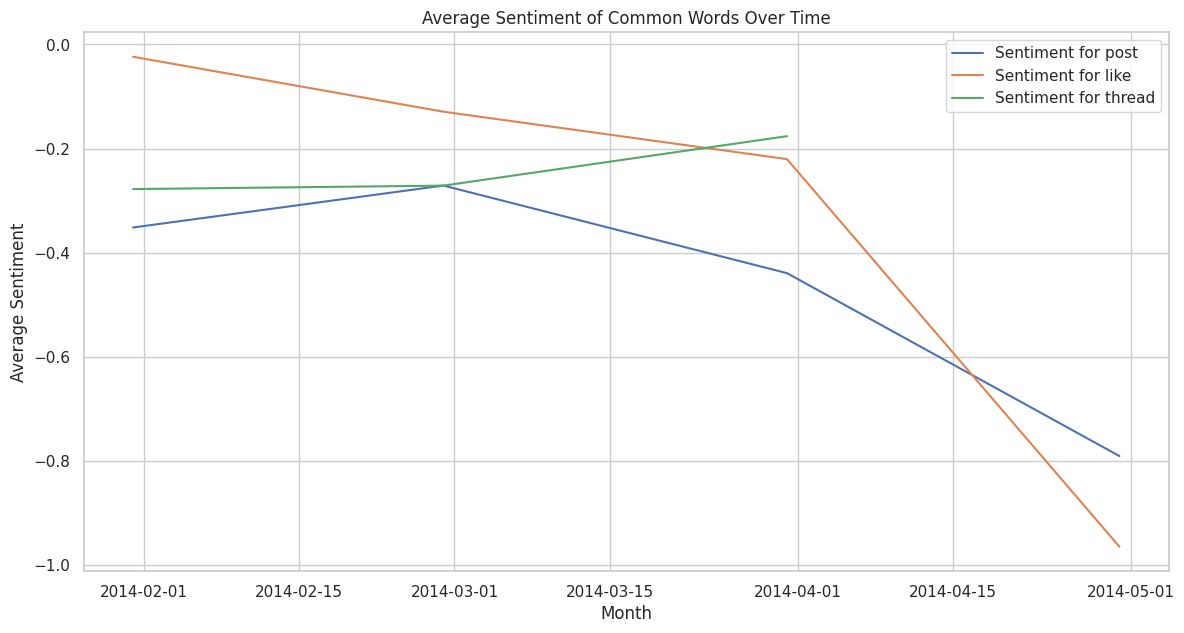

In [228]:
# Plotting the sentiments over time for each common word
plt.figure(figsize=(14, 7))
for word in common_words_set:
    if word in sentiments_over_time.index.levels[0]:  # Check if the word has any data
        sns.lineplot(data=sentiments_over_time[word], label=f"Sentiment for {word}")
plt.title('Average Sentiment of Common Words Over Time')
plt.xlabel('Month')
plt.ylabel('Average Sentiment')
plt.legend()
plt.show()

In [229]:
# Function to get the dominant words from the topics
def get_dominant_words(components, feature_names, n_top_words=5):
    """ Extract the top words from each topic component. """
    dominant_words = []
    for topic_idx, topic in enumerate(components):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        dominant_words.extend(top_words)
    return set(dominant_words)

# Feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Dictionary to store sentiment differences
sentiment_differences = {}

In [230]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [231]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [232]:
print(len(high_similarity_pairs))

29646


In [233]:
# Analyze sentiment differences for similar subreddit pairs
for pair, _ in high_similarity_pairs.items():
    subreddit1, subreddit2 = pair
    common_topics1 = topics_per_subreddit[subreddit1]
    common_topics2 = topics_per_subreddit[subreddit2]

    # Get dominant words for both subreddits
    words1 = get_dominant_words(common_topics1, feature_names)
    words2 = get_dominant_words(common_topics2, feature_names)

    # Find common words in top topics
    common_words = words1.intersection(words2)

    differences = []
    for word in common_words:
        # Extract sentences containing the common word from both subreddits' grouped text
        sentences1 = [sentence for sentence in grouped_data[subreddit1].split('.') if word in sentence]
        sentences2 = [sentence for sentence in grouped_data[subreddit2].split('.') if word in sentence]

        # Get average sentiment score for these sentences
        sentiment1 = np.mean([analyzer.polarity_scores(sentence)['compound'] for sentence in sentences1 if sentences1])
        sentiment2 = np.mean([analyzer.polarity_scores(sentence)['compound'] for sentence in sentences2 if sentences2])

        # Calculate the difference in sentiment

        sentiment_diff = abs(sentiment1 - sentiment2)
        if sentiment_diff:
          differences.append((word, sentiment_diff))

    # Store the results
    sentiment_differences[pair] = differences

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [234]:
# # Print the sentiment differences
# print("Sentiment differences for common topics:")
# for pair, diffs in sentiment_differences.items():
#     print(f"{pair}: {diffs}")

In [235]:
# Filter and keep only the most and the least sentiment differences for each pair
extreme_sentiment_differences = {}

for pair, diffs in sentiment_differences.items():
    if diffs:  # Ensure there are differences recorded
        # Sort differences by the sentiment difference value
        sorted_diffs = sorted(diffs, key=lambda x: x[1])
        # Get the least difference (first element) and the most difference (last element)
        least_diff = sorted_diffs[0]
        most_diff = sorted_diffs[-1]
        # Store only these extremes
        extreme_sentiment_differences[pair] = [least_diff, most_diff]

In [236]:
# # Print the most and least sentiment differences for common topics
# print("Most and least sentiment differences for common topics:")
# for pair, extremes in extreme_sentiment_differences.items():
#     print(f"{pair}: Least - {extremes[0]}, Most - {extremes[1]}")

In [237]:
# Sorting all pairs by the most sentiment difference and the least sentiment difference
sorted_by_most_diff = sorted(extreme_sentiment_differences.items(), key=lambda x: x[1][1][1], reverse=True)  # Most difference
sorted_by_least_diff = sorted(extreme_sentiment_differences.items(), key=lambda x: x[1][0][1])  # Least difference

# Get top 3 pairs with the most and least differences
top_3_most_diff = sorted_by_most_diff[:3]
top_3_least_diff = sorted_by_least_diff[:3]

In [238]:
# Print the results
print("Top 3 subreddit pairs with the most sentiment differences:")
for pair, values in top_3_most_diff:
    print(f"{pair}: {values[1]}")  # values[1] is the tuple with the most difference

print("\nTop 3 subreddit pairs with the least sentiment differences:")
for pair, values in top_3_least_diff:
    print(f"{pair}: {values[0]}")  # values[0] is the tuple with the least difference

Top 3 subreddit pairs with the most sentiment differences:
('badphilosophy', 'erotichypnosis'): ('like', 1.9519)
('changemyview', 'needadvice'): ('think', 1.9502000000000002)
('askreddit', 'needadvice'): ('think', 1.9477)

Top 3 subreddit pairs with the least sentiment differences:
('askhistorians', 'shadowban'): ('im', 0.00019999999999997797)
('askreddit', 'shitredditsays'): ('post', 0.00039999999999995595)
('austinrunning', 'copypasta'): ('like', 0.00040000000000001146)


In [239]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for the plots
sns.set(style="whitegrid")

In [240]:
def plot_sentiment_differences(pairs, title):
    # Prepare the data for plotting
    topics = [f"{pair[0]} vs {pair[1]}" for pair, _ in pairs]
    differences = [values[1][1] for _, values in pairs]
    words = [values[1][0] for _, values in pairs]

    # Create the dataframe
    data = {
        'Subreddit Pair': topics,
        'Difference': differences,
        'Topic Component': words
    }
    df = pd.DataFrame(data)

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(x='Subreddit Pair', y='Difference', hue='Topic Component', dodge=False, data=df)
    plt.title(title)
    plt.xlabel('Subreddit Pairs')
    plt.ylabel('Sentiment Difference')
    plt.xticks(rotation=45)
    plt.legend(title='Topic Component')

    # Show the plot
    plt.show()

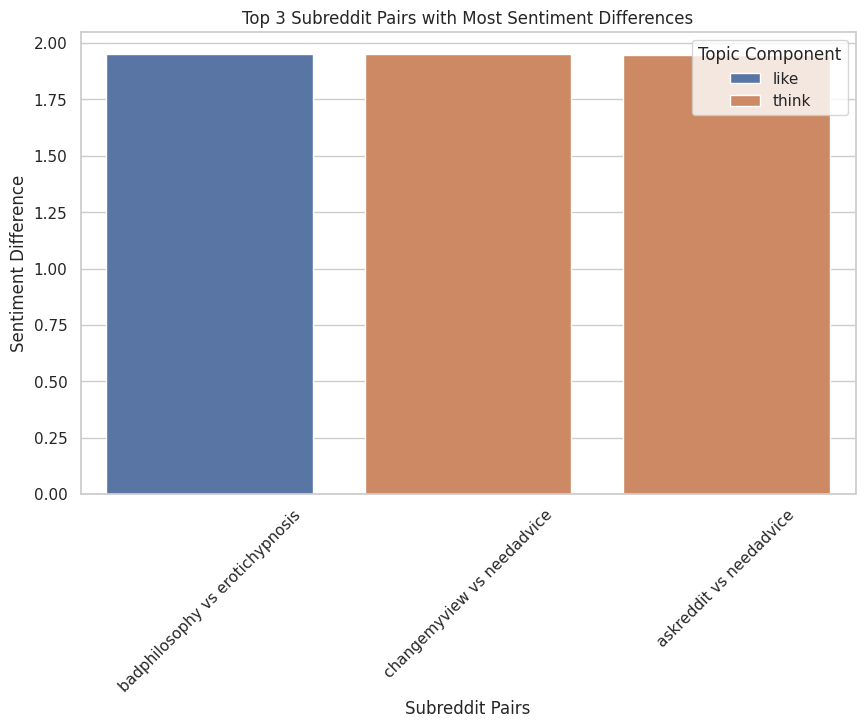

In [241]:
# Visualize the top 3 pairs with the most sentiment differences
plot_sentiment_differences(top_3_most_diff, "Top 3 Subreddit Pairs with Most Sentiment Differences")

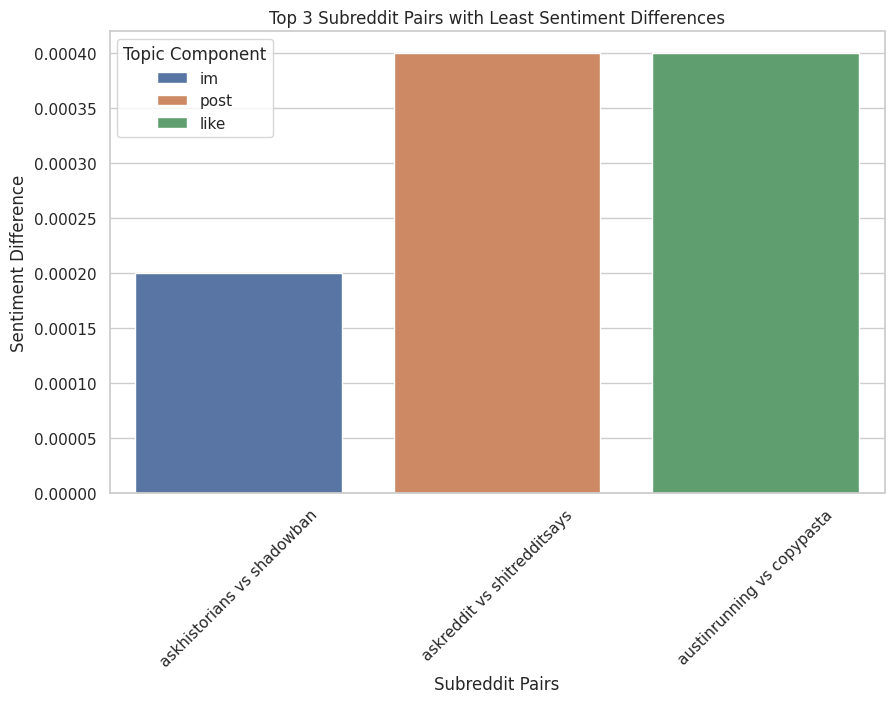

In [242]:
# Visualize the top 3 pairs with the least sentiment differences
plot_sentiment_differences(top_3_least_diff, "Top 3 Subreddit Pairs with Least Sentiment Differences")